In [1]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

import joblib
from joblib import Parallel, delayed

# TERC Data
one_hot, labels, _ = joblib.load("/Users/MacUser/Desktop/CS542/Final_Project/labels.joblib")
y = np.argmax(one_hot, axis=1)
y_array = np.array(one_hot)
#representation_files = ['pca_representation.joblib', "inception_representations.joblib", "resnet_representations.joblib"]

X = joblib.load("/Users/MacUser/Desktop/CS542/Final_Project/resnet_preprocessed.joblib")

Using TensorFlow backend.
/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
Y = y_array #already binarize

# Split into training and test
#X_train, X_test, y_train_array, y_test_array =  train_test_split(X, Y, random_state=42)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

# We use OneVsRestClassifier for multi-label prediction
#from sklearn.multiclass import OneVsRestClassifier
# (Sample code) Run classifier
#classifier = OneVsRestClassifier(svm.LinearSVC(random_state=random_state))
#classifier.fit(X_train, Y_train)
#y_score = classifier.decision_function(X_test)

# Our model
#model = load_model("/Users/MacUser/Desktop/CS542/Final_Project/resnet_single_model-final.hdf5")
#y_score = model.predict(np.array(X_train)) #y_predict same as y_score


In [3]:
dataset_size = len(X_train)
X_train = np.asarray(X_train)
X_train = X_train.reshape(dataset_size,-1)

In [4]:
#Use SVM first 
from sklearn.multiclass import OneVsRestClassifier

classifier = OneVsRestClassifier(svm.LinearSVC(random_state=42))
classifier.fit(X_train, Y_train)
y_score = classifier.decision_function(X_test)

ValueError: Found array with dim 4. Estimator expected <= 2.

In [9]:
dataset_size = len(X_test)
X_test = np.asarray(X_test)
X_test = X_test.reshape(dataset_size, -1)
y_score = classifier.decision_function(X_test)

In [10]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
n_classes = Y.shape[1]
precision = dict()
recall = dict()
average_precision = dict()

print(Y_test.shape)
print(y_score.shape)
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

(241, 11)
(241, 11)
Average precision score, micro-averaged over all classes: 0.36


In [11]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

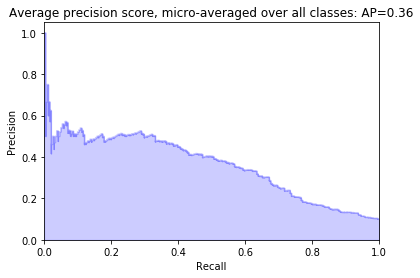

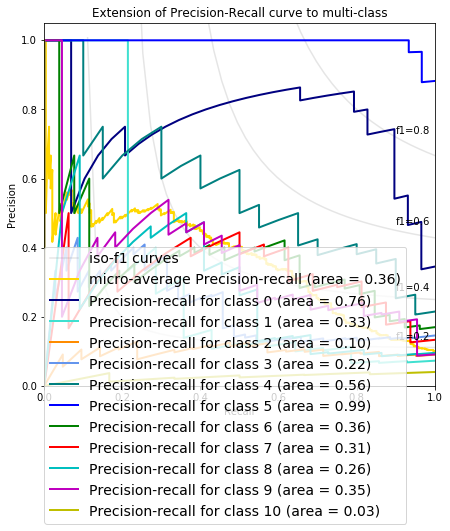

In [12]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'b', 'g', 'r', 'c', 'm', 'y', 'y', 'g'])


plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()